# Tutorial of implementing Generative Adversarial Net
mnist image에 대하여 Generative Adversarial Net을 학습하고, 학습된 Generator를 이용하여 mnist image를 Generate 해보는 예제
  
* Paper 
    * [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)
* Reference
    * https://github.com/golbin/TensorFlow-Tutorials/blob/master/09%20-%20GAN/01%20-%20GAN.py
    * https://github.com/hwalsuklee/tensorflow-generative-model-collections/blob/master/GAN.py
    * https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/

### Setup

In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data # load mnist dataset
mnist = input_data.read_data_sets(train_dir = './data/MNIST_data/', one_hot = True, reshape = True, seed = 777)
print(tf.__version__)

slim = tf.contrib.slim

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz
1.6.0


### Define GAN class

In [2]:
class Generator:
    def __init__(self, input_dim, h_dims = [256]):
        self._input_dim = input_dim
        self._h_dims = h_dims
        
    def __call__(self, z):
        with tf.variable_scope('generator', reuse = tf.AUTO_REUSE):
            _net = z
            
            with slim.arg_scope([slim.fully_connected], activation_fn = tf.nn.tanh,
                                weights_initializer = slim.xavier_initializer()):
            
                for layer, h_dim in enumerate(self._h_dims):
                    with tf.variable_scope('hidden_layer{}'.format(layer + 1)):
                        _net = slim.fully_connected(inputs = _net, num_outputs = h_dim)
                        
                with tf.variable_scope('output_layer'):
                    _output = slim.fully_connected(inputs = _net, num_outputs = self._input_dim,
                                               activation_fn = tf.nn.sigmoid)
        return _output

In [3]:
class Discriminator:
    def __init__(self, h_dims = [256]):
        self._h_dims = h_dims
        
    def __call__(self, inputs):
        with tf.variable_scope('discriminator', reuse = tf.AUTO_REUSE):
            _net = inputs
            
            with slim.arg_scope([slim.fully_connected], activation_fn = tf.nn.tanh,
                                 weights_initializer = slim.xavier_initializer()):
                
                for layer, h_dim in enumerate(self._h_dims):
                    with tf.variable_scope('hidden_layer{}'.format(layer + 1)):
                        _net = slim.fully_connected(inputs = _net, num_outputs = h_dim)
                        
                with tf.variable_scope('output_layer'):
                    _score = slim.fully_connected(inputs = _net, num_outputs = 1,
                                                         activation_fn = None)
        return _score

In [4]:
class GAN:
    def __init__(self, z_dim, input_dim, g_h_dims, d_h_dims):
       
        self._z = tf.placeholder(dtype = tf.float32, shape = [None, z_dim])
        self._inputs = tf.placeholder(dtype = tf.float32, shape = [None, input_dim])

        
        self._generator = Generator(input_dim = input_dim, h_dims = g_h_dims)
        self._discriminator = Discriminator(h_dims = d_h_dims)

        self._fake = self._generator(z = self._z)
        
        d_logits_real = self._discriminator(inputs = self._inputs)
        d_logits_fake = self._discriminator(inputs = self._fake)
        
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_logits_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_logits_fake)))
                
        self._loss_D = d_loss_real + d_loss_fake
        self._loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_logits_fake)))

    def generate(self, sess, z):
        feed_generate = {self._z : z}
        return sess.run(fetches = self._fake, feed_dict = feed_generate)

### Define Solver

In [5]:
class SolverForDiscriminator:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        self._training_op = self._optimizer.minimize(loss = self._model._loss_D,
                                                         var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                                                                      scope = 'discriminator'))
    def train(self, sess, z, inputs, lr):
        feed_train = {self._model._z : noise, self._model._inputs : inputs, self._lr : lr}
        return sess.run(fetches = [self._training_op, self._model._loss_D], feed_dict = feed_train)

In [6]:
class SolverForGenerator:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        
        self._training_op = self._optimizer.minimize(loss = self._model._loss_G,
                                                         var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                                                                      scope = 'generator'))
    def train(self, sess, z, lr):
        feed_train = {self._model._z : z, self._lr : lr}
        return sess.run(fetches = [self._training_op, self._model._loss_G], feed_dict = feed_train)

### Training

In [7]:
gan = GAN(z_dim = 50, input_dim = 784, g_h_dims = [100], d_h_dims = [100])

In [8]:
solver_for_g = SolverForGenerator(model = gan)
solver_for_d = SolverForDiscriminator(model = gan)

In [9]:
#hyper-parameter
epochs = 25
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
# training
loss_D_hist = []
loss_G_hist = []
sampled = []

for epoch in range(epochs):
    avg_loss_D, avg_loss_G = 0, 0
    
    for step in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size = batch_size)
        noise = np.random.randn(batch_size, 50)
        
        _, loss_D = solver_for_d.train(sess = sess, z = noise, inputs = batch_xs, lr = 1e-4)
        _, loss_G = solver_for_g.train(sess = sess, z = noise, lr = 1e-4)
        avg_loss_D += loss_D / total_batch 
        avg_loss_G += loss_G / total_batch
        
    print('epoch : {:3}. D loss : {:.3f}, G loss : {:.3f}'.format(epoch, avg_loss_D, avg_loss_G))
    loss_D_hist.append(avg_loss_D)
    loss_G_hist.append(avg_loss_G)
    
    if (epoch + 1) % 5 == 0:
        sampled.append(gan.generate(sess = sess, z = np.random.randn(5,50)))

epoch :   0. D loss : 0.092, G loss : 5.224
epoch :   1. D loss : 0.084, G loss : 8.830
epoch :   2. D loss : 0.180, G loss : 6.948
epoch :   3. D loss : 0.352, G loss : 6.012
epoch :   4. D loss : 0.322, G loss : 3.995
epoch :   5. D loss : 0.207, G loss : 2.852
epoch :   6. D loss : 0.205, G loss : 2.735
epoch :   7. D loss : 0.235, G loss : 2.716
epoch :   8. D loss : 0.205, G loss : 2.693
epoch :   9. D loss : 0.243, G loss : 2.596
epoch :  10. D loss : 0.303, G loss : 2.368
epoch :  11. D loss : 0.285, G loss : 2.322
epoch :  12. D loss : 0.280, G loss : 2.348
epoch :  13. D loss : 0.266, G loss : 2.452
epoch :  14. D loss : 0.282, G loss : 2.404
epoch :  15. D loss : 0.258, G loss : 2.503
epoch :  16. D loss : 0.258, G loss : 2.520
epoch :  17. D loss : 0.228, G loss : 2.602
epoch :  18. D loss : 0.224, G loss : 2.663
epoch :  19. D loss : 0.201, G loss : 2.826
epoch :  20. D loss : 0.218, G loss : 2.829
epoch :  21. D loss : 0.235, G loss : 2.818
epoch :  22. D loss : 0.213, G l

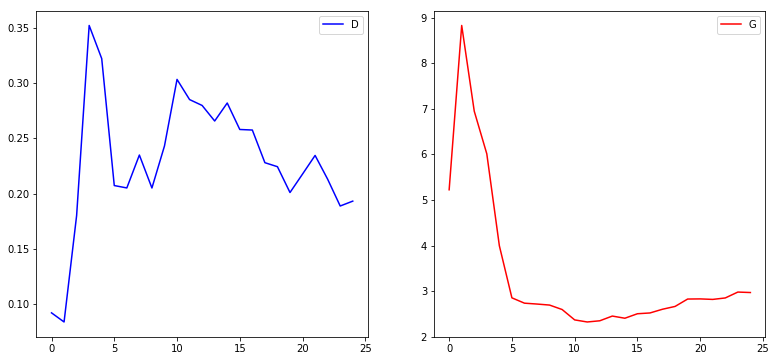

In [12]:
# visualize loss
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(right = .8)
fig.add_subplot(1,2,1)
plt.plot(loss_D_hist, label = 'D', c = 'b')
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(loss_G_hist, label = 'G', c= 'r')
plt.legend()

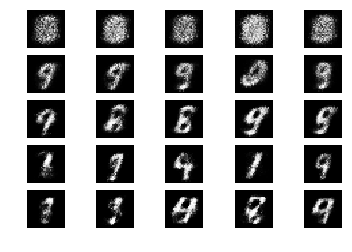

In [13]:
# epoch 5마다 Generator가 random noise로 부터 생성한 손글씨 plot
for i in range(np.shape(sampled)[0]):
    for j in range(np.shape(sampled)[1]):
        plt.subplot2grid((np.shape(sampled)[0],np.shape(sampled)[1]),(i,j))
        plt.axis('off')
        plt.imshow(sampled[i][j].reshape(28,28), cmap = 'gray')